# główny plik


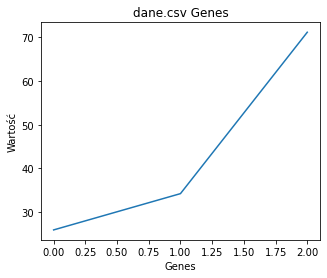

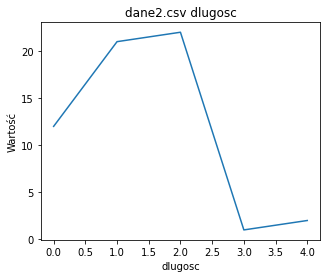

In [3]:
#importowanie
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
import tkinter.font as tkFont
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.stats import shapiro
import os
    
#klasy
class SimpleStatisticsApp:
    #ustawienia wstępne
    def __init__(self):
        #okno
        self.good_data = 0
        self.root = tk.Tk()
        self.root.title("Prosta Statystyka")
        self.root.geometry('620x300')
        
        #zmienne
        self.table_removed = False
        self.table_data = None
        self.file_name = ""
        
        #potrzebne do przewijania
        self.frame = tk.Frame(self.root)
        self.canvas = tk.Canvas(self.root)
        self.scrollbar_y = tk.Scrollbar(self.root, orient='vertical', command=self.canvas.yview)
        self.scrollbar_x = tk.Scrollbar(self.root, orient='horizontal', command=self.canvas.xview)
        self.canvas.configure(yscrollcommand=self.scrollbar_y.set)
        self.canvas.configure(xscrollcommand=self.scrollbar_x.set)  
        self.content = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.content, anchor='nw')

        #wyświetlanie tekstu
        self.text1 = tk.StringVar()
        self.text2 = tk.StringVar()
        self.label1 = tk.Label(self.content, textvariable=self.text1)
        self.label2 = tk.Label(self.content, textvariable=self.text2)
        self.label1.pack(pady=1)
        self.label2.pack(pady=1)
        self.text1.set("Witaj w prostym programie statystycznym!\n"
                       "Program wyświetla wykresy, sprawdza rozkład normalny, oraz wyświetla podstawową statystykę.\n"
                       "By zamknąć wszystko kliknij 'x' w głównym oknie 'Prosta Statystyka'.")
        self.text2.set("By rozpocząć kliknij przycisk poniżej:")

        self.text_info = ""
        self.label_info = tk.Label(self.content, text=self.text_info)
        self.label_info.pack()
        self.label = tk.Label(self.content, text="")
        self.label.pack()

        #przycisk do wybierania pliku
        self.button = tk.Button(self.content, text="Wybierz plik CSV", command=self.display_csv_data)
        self.button.pack(pady=1)
        self.result_label = tk.Label(self.content, text = " ")
        self.result_label.pack()

        #do przewijania
        self.scrollbar_y.pack(side='right', fill='y')
        self.scrollbar_x.pack(side='bottom', fill='x')
        self.frame.pack(fill='both', expand=False)
        self.canvas.pack(side='left', fill=tk.BOTH, expand=True)
        self.content.update_idletasks()
        self.canvas.configure(scrollregion=self.canvas.bbox('all'))  

        
    def run(self):
        self.root.mainloop()
        

    #aktualizowanie informacji
    def update_label_info(self, text):
        self.text_info = text
        self.label_info.config(text=self.text_info)

    def update_label(self, text):
        self.label.config(text=text)      
        
        
    def display_csv_data(self):
        #uruchamianie innych klas
        filepath = filedialog.askopenfilename(filetypes=[("Pliki CSV", "*.csv")])
        if filepath:
            self.Csv_class = CSVData(filepath)
            self.Csv_class.display_csv_data() #czy coś potrzeba?
            
            if app.good_data == 2:      #sprawdzanie czy dane są dobre
                self.file_name = str(os.path.basename(filepath))

                self.Csv_table_class = CSVTableDisplay(filepath,app) #dodanie linku do innej klasy
                self.Csv_table_class.display_csv_table() #użycie funkcji innej klasy 

                self.Shapiro_class = ShapiroTest()
                self.Shapiro_class.perform_shapiro_test(filepath)
                
                self.Visualization_class = DataVisualization(filepath)
                self.Visualization_class.show_data()    

                
                self.label2.destroy()
                self.update_label("")
                self.label_info.config(text=self.Csv_class.text_info)
                self.label_info.pack(pady=1)
                
            #by przy kolejnym wyborze było dobrze
            self.good_data = 0
            self.text_info = " "
              
        
class CSVData:
    def __init__(self, filepath):
        self.filepath = filepath
        self.label_info = app.label_info
        self.text_info = app.text_info
        

    def display_csv_data(self):
        self.text_info = "Pierwszy wiersz i pierwsza kolumna to nagłówki (tego nie sprawdzam). \n\
Pozostałe komórki powinny być wypełnione liczbami oraz nie powinny zawierać pustych miejsc.\n\
Sprawdzam czy dane są poprawne...\n"
        
        if self.filepath:
            data = pd.read_csv(self.filepath)
            
            # Lokalizacja pustych miejsc
            null_locations = []
            for row in range(len(data)):
                for col in range(1, len(data.columns)):  # Pomiń pierwszą kolumnę
                    if pd.isna(data.iloc[row, col]):
                        null_locations.append((row, col))

            # Lokalizacja wartości niebędących liczbami
            non_numeric_locations = []
            for row in range(len(data)):
                for col in range(1, len(data.columns)):  # Pomiń pierwszą kolumnę
                    try:
                        float(data.iloc[row, col])
                    except ValueError:
                        non_numeric_locations.append((row, col))

            # Informacja czy zawiera puste komórki i gdzie
            if not null_locations:
                self.text_info += "\nSuper! Tabela nie zawiera pustych komórek."
                app.good_data += 1
            else:
                self.text_info += "\nBłąd! Tabela zawiera puste miejsca. \
By użyć tych danych musisz to poprawić. To jest ich lokalizacja:\n"
                for row, col in null_locations:
                    self.text_info +=  f" - Wiersz: {row+1}, Kolumna: {data.columns[col]}\n"
                    

            # Informacja czy zawiera dane nienumeryczne i gdzie
            if not non_numeric_locations:
                self.text_info += "\nSuper! Tabela nie zawiera danych inne niż liczby.\n"
                app.good_data +=1
            else:
                self.text_info += "\nBłąd! Tabela zawiera dane inne niż liczby. \
By użyć tych danych musisz to poprawić. To jest ich lokalizacja:\n"
                for row, col in non_numeric_locations:
                    self.text_info += f" - Wiersz: {row+1}, Kolumna: {data.columns[col]}\n"
      

            #sprawdzenie pliku i wybranie odpowiedniego działania    
            if app.good_data == 2:
                app.label_info.config(text=self.text_info)
                app.label_info.pack(pady=1)
            else:
                self.text_info += "\n\nSprawdź poprawność wprowadzonych danych we wskazanych miejscach, wtedy wróć ponownie ;)"
                #app.label_info.config(text=text_info)
                messagebox.showinfo("Błąd!",self.text_info )    
                
    
class CSVTableDisplay:
    def __init__(self, filepath, app):
        #wprowadza zmienne
        self.filepath = filepath
        self.content = app.content
        self.canvas = app.canvas
        self.table_removed = app.table_removed
        self.table_data = app.table_data
        

    def remove_table(self):
        #usuwa tabelę jeśli jest
        if app.table_data is not None:
            app.table_data.destroy()
            app.table_data = None
            app.table_removed = True
        if app.table_removed:
            return

        
    def display_csv_table(self):
        # Wyświetlanie tabeli z danych
        self.remove_table()
        data = pd.read_csv(self.filepath)

        nazwy_kolumn = tuple(data.columns) #by można się było odnosić do nazw nieznanych kolumn
        app.table_data = ttk.Treeview(app.content, columns=nazwy_kolumn, show='headings')

        
        for n in range(len(nazwy_kolumn)):
            app.table_data.heading(nazwy_kolumn[n], text=nazwy_kolumn[n])

        for index, row in data.iterrows():
            app.table_data.insert("", "end", values=list(row))

        lista_kolumn = []
        for kolumna in nazwy_kolumn:
            lista_kolumn.append(data[kolumna].tolist())

        label_data() #by była jedna etykietka tabeli
        app.table_data.pack() #przyczepia tabelę
        
        
        #aktualizacja okna - by mogło być przewijane
        app.content.update_idletasks()
        app.canvas.configure(scrollregion=app.canvas.bbox('all'))        
        
        
class ShapiroTest:
    #sprawdza czy dane mają rozkład normalny i pokazuje podstawową statystykę
    def __init__(self):
        self.result_label = app.result_label

    def perform_shapiro_test(self, filepath):
        text_end = "\n\nStatystyka dla pliku " + str(app.file_name) + ":"
        
        if filepath:
            data = pd.read_csv(filepath, index_col=0, header=0) # Wczytanie danych z pliku CSV z nagłówkami w kolumnach i wierszach
            nazwy_kolumn = data.columns                         # Pobranie nazw kolumn od startowej kolumny do końca
            lista_kolumn = []                                   # Podział na poszczególne kolumny
            
            for kolumna in nazwy_kolumn:
                lista_kolumn.append(data[kolumna].tolist())

            for i, kolumna in enumerate(nazwy_kolumn):          # Wyświetlenie danych w poszczególnych kolumnach
                if type(lista_kolumn[i]) == float or int:    # Wykonanie testu Shapiro-Wilka
                    statistic, p_value = shapiro(lista_kolumn[i])
                    
                    alpha = 0.05          # Sprawdzenie hipotezy
                    if p_value > alpha:
                        if_normal = " Dane mają rozkład normalny" # wyniki tylko tam gdzie można
                        column_means = data[kolumna].mean()
                        column_var = data[kolumna].var()
                        column_stds = data[kolumna].std()
                        
                        #wyświetla wynik
                        text_inf_alpha = f"Ponieważ kolumna '{kolumna}' posiada rozkład normalny:\n\
Średnia arytmetyczna: {column_means:>5.5f}\nWariancja: {column_var:>5.5f}\nOdchylenie standardowe: {column_stds:>5.5f}\n\n"
                                            
                    else:
                        if_normal = " Dane NIE mają rozkładu normalnego"
                        column_med = data[kolumna].median() # obliczanie mediany
                        
                        text_inf_alpha = f"Ponieważ kolumna '{kolumna}' NIE posiada rozkładu normalnego:\n\
Mediana: {column_med:>5.5f}\n\n"
      
                    # Wyświetlenie wyników testu
                    text_inf = f"\n\nTest Shapiro-Wilka dla kolumny '{kolumna}':\nStatystyka testowa: {statistic:>5.5f}\nWartość p: {p_value:>5.5f} \nWerdykt:{if_normal}\n\n"
                    text_end = text_end + text_inf + text_inf_alpha
                    app.result_label.config(text=text_end)
                else:
                    app.result_text = "Dane są niepoprawne, sprawdź poprawność wprowadzonych danych"
       
        
        #aktualizacja okna - by mogło być przewijane
        app.result_label.pack()
        app.content.update_idletasks()
        app.canvas.configure(scrollregion=app.canvas.bbox('all'))
        
        
class DataVisualization:
    #przedstawienie danych na wykresach
    def __init__(self, filepath):
        self.filepath = filepath
        self.file_name = str(os.path.basename(filepath))
        self.fig = None
        self.canvas = None
        self.data = pd.read_csv(self.filepath)
        
    def show_data(self):
        # Tworzenie nowego okna WYKRESY
        data_window = tk.Toplevel()
        data_window.title("wykresy")

        # Tworzenie etykiet i list rozwijanych
        label_chart1 = tk.Label(data_window, text="By wyświetlić wykres:\nWybierz kolumnę:")
        label_chart1.pack(pady=1)

        columns = self.data.columns.tolist()
        selected_columns = tk.StringVar(value=columns)
        columns_combobox = ttk.Combobox(data_window, values=columns, state="readonly")
        columns_combobox.pack(pady=5)

        label_chart2 = tk.Label(data_window, text="Oraz typ wykresu:")
        label_chart2.pack(pady=1)

        #wybieranie typu wykresu
        plot_types = ["histogram", "liniowy", "słupkowy", "punktowy"]
        selected_plot_type = tk.StringVar(value=plot_types[0])
        plot_types_combobox = ttk.Combobox(data_window, values=plot_types, state="readonly")
        plot_types_combobox.pack(pady=5)

        plot_button = tk.Button(data_window, text="Wyświetl wykres",
                                command=lambda: self.plot_data(columns_combobox.get(), plot_types_combobox.get()))
        plot_button.pack()

        self.plot_frame = tk.Frame(data_window)
        self.plot_frame.pack()

        def save_plot():
            #zapisuje wykres
            filepath = filedialog.asksaveasfilename(defaultextension=".png",
                                                    filetypes=[("Obraz PNG", "*.png"), ("Obraz JPEG", "*.jpg")])
            if filepath:
                self.fig.savefig(filepath)
                messagebox.showinfo("Zapisano", "Wykres został zapisany do pliku.")

        self.save_button = tk.Button(data_window, text="Zapisz wykres", command=save_plot)
        self.save_button.pack()

        self.save_button["state"] = "disabled"

    def plot_data(self, selected_column, selected_plot_type):
        #rysuje wykres
        if self.fig is not None:   #usuwa jeśli jakiś wykres był wcześniej
            plt.close(self.fig)
            self.canvas.get_tk_widget().destroy()

        self.fig, ax = plt.subplots(figsize=(5, 4))

        #realizacja typu wykresu
        if selected_plot_type == "histogram":
            plt.hist(self.data[selected_column], bins=10)
        elif selected_plot_type == "liniowy":
            ax.plot(self.data[selected_column])
        elif selected_plot_type == "słupkowy":
            ax.bar(self.data.index, self.data[selected_column])
        elif selected_plot_type == "punktowy":
            ax.scatter(self.data.index, self.data[selected_column])

        ax.set_xlabel(selected_column)
        ax.set_ylabel("Wartość")
        ax.set_title(self.file_name + " " + selected_column)

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.plot_frame)
        self.canvas.draw()

        self.canvas.get_tk_widget().pack()

        self.save_button["state"] = "normal"        
        

            
#definicja            
def label_data():
    #wyświetla etykietkę
    global count

    if count == 0:
        label = tk.Label(app.content, text="Oto tabela z danymi:") 
        label.pack(pady=1)
        count +=1             

    
    
# Program główny
# Tworzenie i uruchomienie aplikacji
count = 0

app = SimpleStatisticsApp()
app.run()




In [13]:
    #def adjust_table_height(data):
    #    # Pobierz liczbę wierszy w tabeli
    #    num_rows = len(data.get_children())

     #   # Ustaw wysokość tabeli na podstawie liczby wierszy
     #   table_height = min(num_rows)  # Maksymalnie 10 wierszy
     #   table_data['height'] = table_height

NameError: name 'window' is not defined